In [15]:
import os
import pandas as pd
from tstrends.label_tuning.remaining_value_tuner import RemainingValueTuner
from tstrends.trend_labelling import OracleTernaryTrendLabeller
from tstrends.visualization import plot_trend_labels

# Getting the labels to tune

First, we'll perform standard ternary trend labeling using the OracleTernaryTrendLabeller to generate initial labels.
This is a straightforward labeling process without any optimization or returns estimation.

In [2]:
df_list = []
for file in os.listdir('/workspaces/python-trend-labeller/notebooks/data'):
    if file.endswith('.parquet'):
        df_list.append(pd.read_parquet(f'/workspaces/python-trend-labeller/notebooks/data/{file}'))


In [3]:
df_concat = pd.concat(df_list).sort_values(by='t')
df_concat.drop_duplicates(subset='t', keep='first', inplace=True)

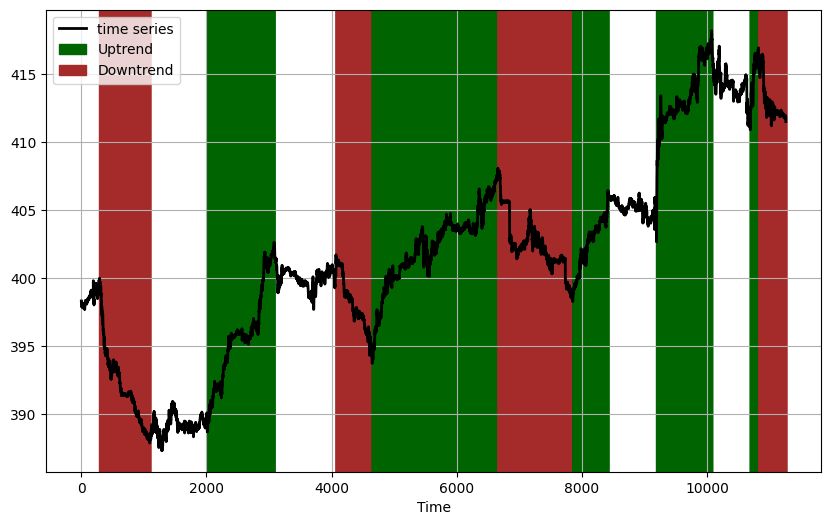

In [4]:
labels = OracleTernaryTrendLabeller(transaction_cost=0.006, neutral_reward_factor=0.03).get_labels(df_concat.c.tolist())
plot_trend_labels(df_concat.c.tolist(), labels)

# Tuning the labels

Trend labeling is often performed as an intermediate step in training a predictive model. However, binary (or ternary) systems may not capture some important nuances. For example, in trading use cases:
* Correctly predicting an uptrend is critical at the beginning of the trend, but becomes less relevant near the end.
* The impact of a correct prediction depends on the magnitude of the trend's total price change.

Hence, we can use the **RemainingValueTuner** to transform the labels into a float that expresses, for each time i, the difference between the maximum/minimum of the trend and the actual value at time i.

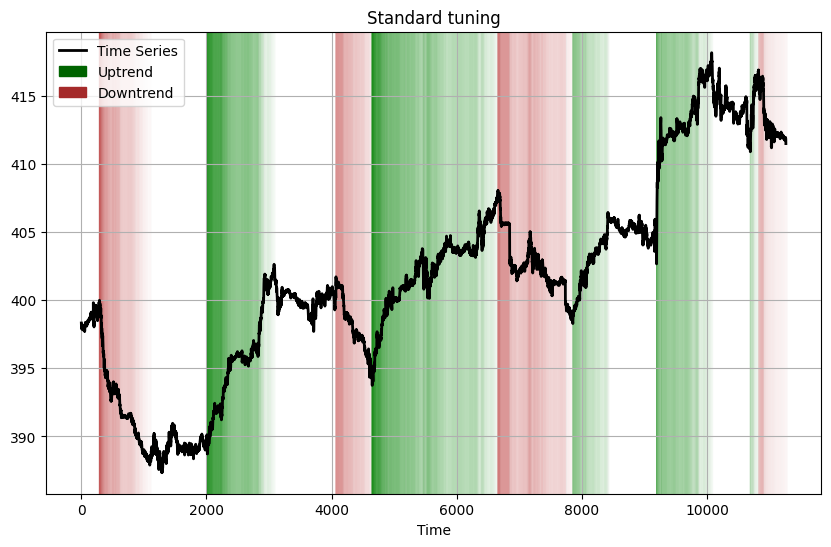

In [5]:
from tstrends.visualization.utils import plot_trend_labels_with_gradation

tuned_labels = RemainingValueTuner().tune(df_concat.c.tolist(), labels)

plot_trend_labels_with_gradation(df_concat.c.tolist(), tuned_labels, title="Standard tuning")

To normalize the values within each trend interval to a common scale, use the *normalize_over_interval* parameter.

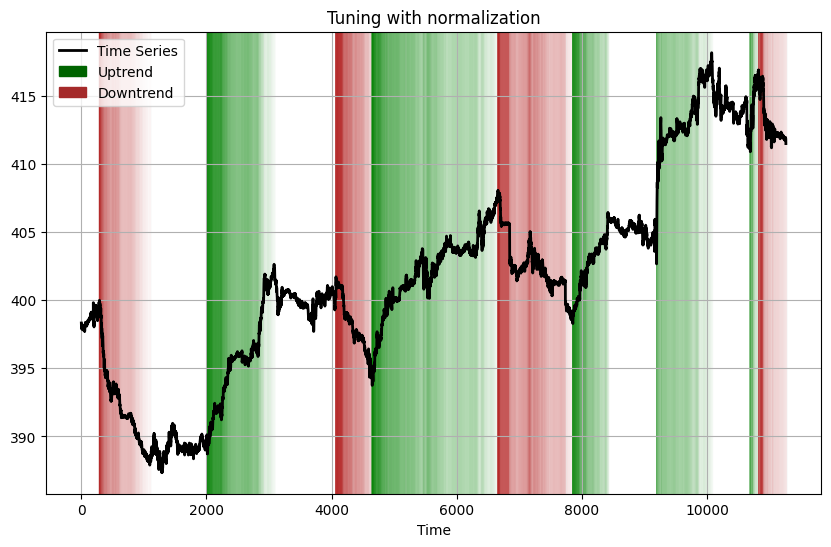

In [6]:
tuned_labels = RemainingValueTuner().tune(df_concat.c.tolist(), labels, normalize_over_interval=True)

plot_trend_labels_with_gradation(df_concat.c.tolist(), tuned_labels, title="Tuning with normalization")

For some use cases, having non-monotonic value sequences can be problematic. We can enforce monotonicity of the generated series using the *enforce_monotonicity* parameter.

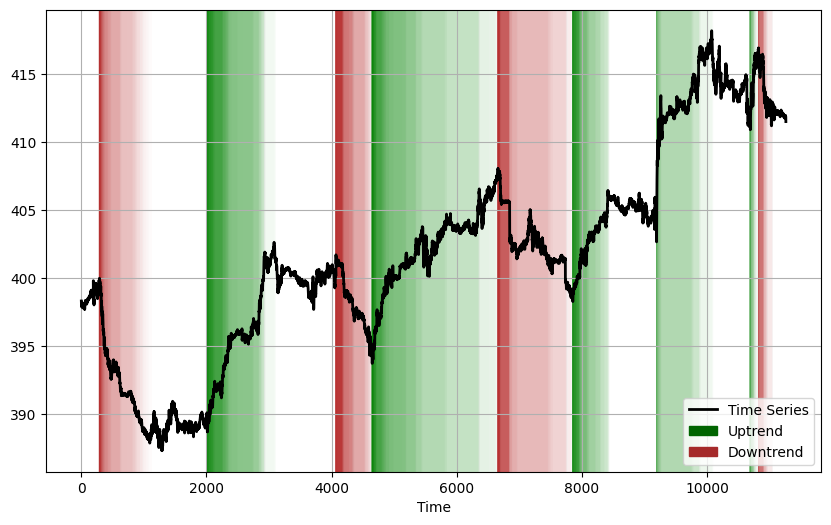

In [7]:
tuned_labels = RemainingValueTuner().tune(df_concat.c.tolist(), labels, enforce_monotonicity=True, normalize_over_interval=True)

plot_trend_labels_with_gradation(df_concat.c.tolist(), tuned_labels)

# Smoothing and shifting

Smoothing the series can help to reduce some harmful noise in the signal.
As in v0.3.0 there are two main smoothers inplemented:
* **SimpleMovingAverage**: Applies equal weights to all values in the window, resulting in uniform smoothing.
* **LinearWeightedAverage**: Applies linearly increasing weights to values in the window, giving more importance to recent values and less to older ones. This creates a more responsive smoothing that better preserves the shape of trends.

They have two main parameters, the *window size* and the *direction* ("left" shifting the tuned labels to preceed the trend or "centered").

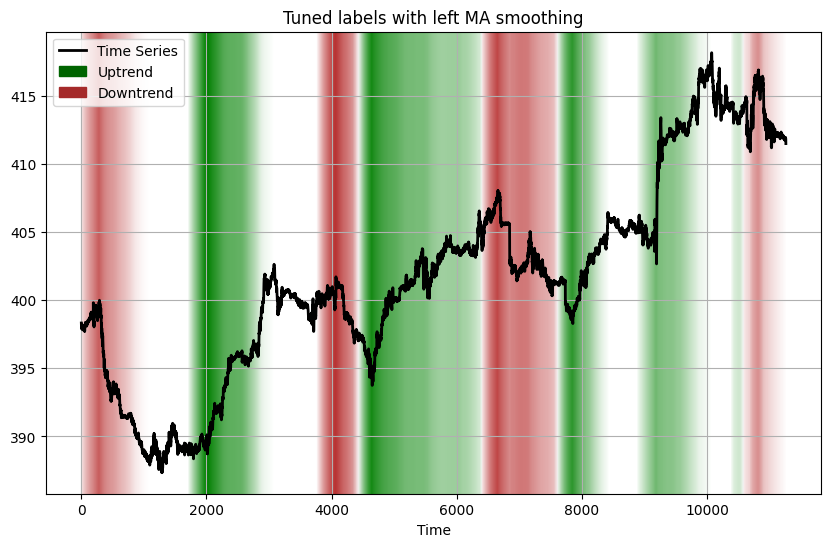

In [8]:
from tstrends.label_tuning.smoothing import SimpleMovingAverage

smoother = SimpleMovingAverage(window_size=300)

tuned_labels_with_smoothing = RemainingValueTuner().tune(df_concat.c.tolist(), labels, normalize_over_interval=True, smoother=smoother)
plot_trend_labels_with_gradation(df_concat.c.tolist(), tuned_labels_with_smoothing, title="Tuned labels with left MA smoothing")

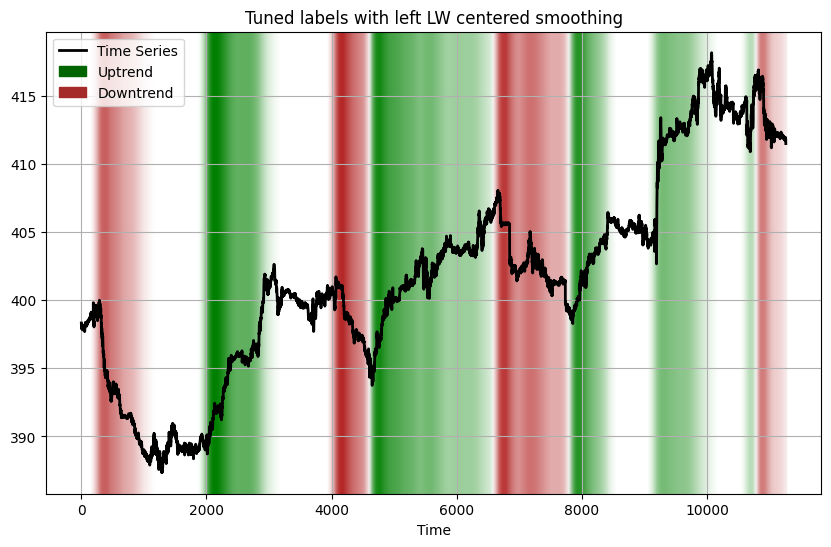

In [9]:
from tstrends.label_tuning.smoothing import LinearWeightedAverage


smoother = LinearWeightedAverage(window_size=300, direction="centered")
tuned_labels_with_smoothing = RemainingValueTuner().tune(df_concat.c.tolist(), labels, normalize_over_interval=True, smoother=smoother)
plot_trend_labels_with_gradation(df_concat.c.tolist(), tuned_labels_with_smoothing,title="Tuned labels with left LW centered smoothing")

Lastly, the shifting effect can be achieved explicitly with the *shift_periods* parameter of the tune method. Note that the shifting is done before the smoothing to avoid a sharp decay on the shifted side.

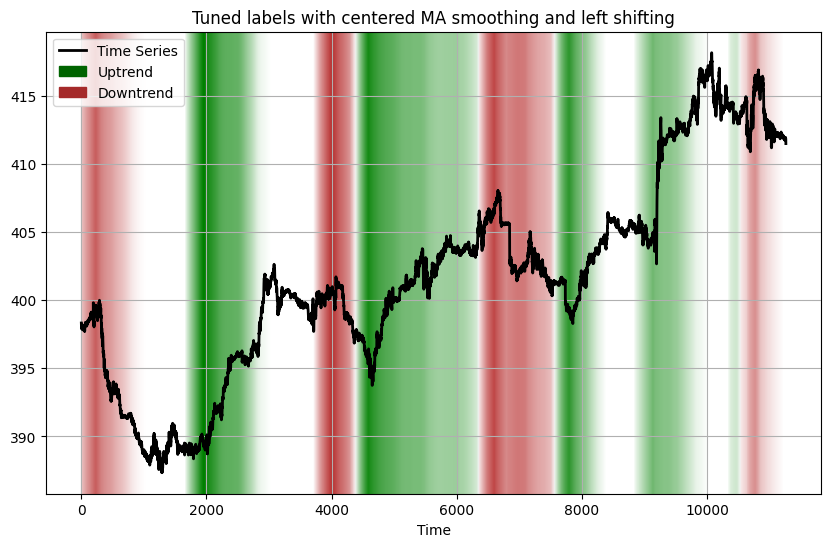

In [14]:
smoother = SimpleMovingAverage(window_size=300, direction="centered")

tuned_labels_with_smoothing = RemainingValueTuner().tune(
    df_concat.c.tolist(),
    labels,
    normalize_over_interval=True,
    shift_periods=-200,
    smoother=smoother,
)
plot_trend_labels_with_gradation(
    df_concat.c.tolist(),
    tuned_labels_with_smoothing,
    title="Tuned labels with centered MA smoothing and left shifting",
)